In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
import warnings

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [78]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

# Data Cleaning: Y-values

In [79]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

### Min-max scaling

In [80]:
scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

2019-10-01 00:00:00
2023-04-30 23:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


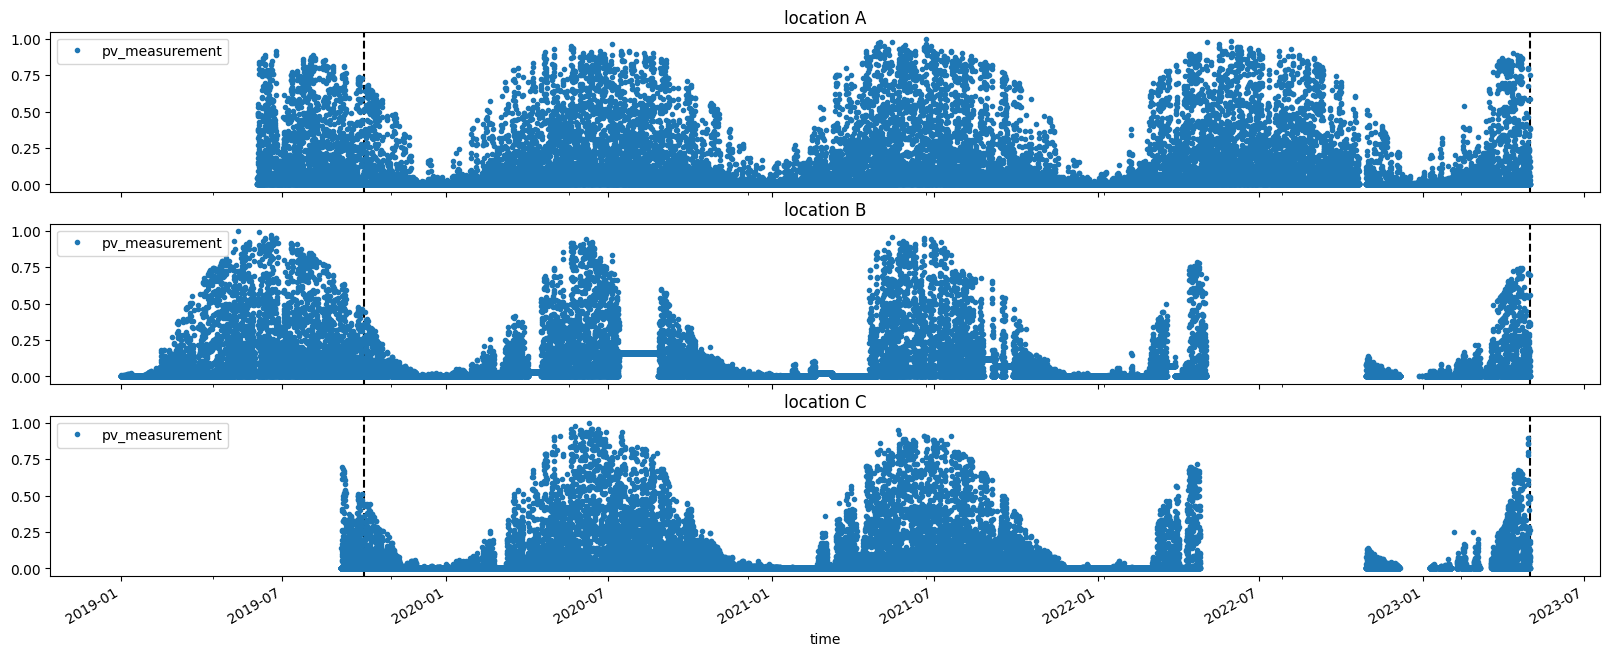

In [81]:
# Define the overall start and end dates
#overall_start = max(train_b.index.min(), train_c.index.min(), train_a.index.min())
overall_start = pd.Timestamp("2019-10-01 00:00:00")
overall_end = min(train_a.index.max(), train_b.index.max(), train_c.index.max())

print(overall_start)
print(overall_end)

print(type(overall_start))

fig, axs = plt.subplots(3, 1, figsize=(20,8), sharex=True)

# Add vertical lines to each subplot
for ax in axs:
    ax.axvline(overall_start, color="black", ls="--")
    ax.axvline(overall_end, color = "black", ls = "--")

#Plotting
train_a[['pv_measurement']].plot(ax=axs[0], title="location A", style=".")
train_b[['pv_measurement']].plot(ax=axs[1], title="location B", style=".")
train_c[['pv_measurement']].plot(ax=axs[2], title="location C", style=".")

plt.show()


In [82]:
# Create a complete date range
full_date_range = pd.date_range(start=overall_start, end=overall_end, freq='H')

# Reindexing
train_a = train_a.reindex(full_date_range)
train_b = train_b.reindex(full_date_range)
train_c = train_c.reindex(full_date_range)

<Axes: title={'center': 'location C'}>

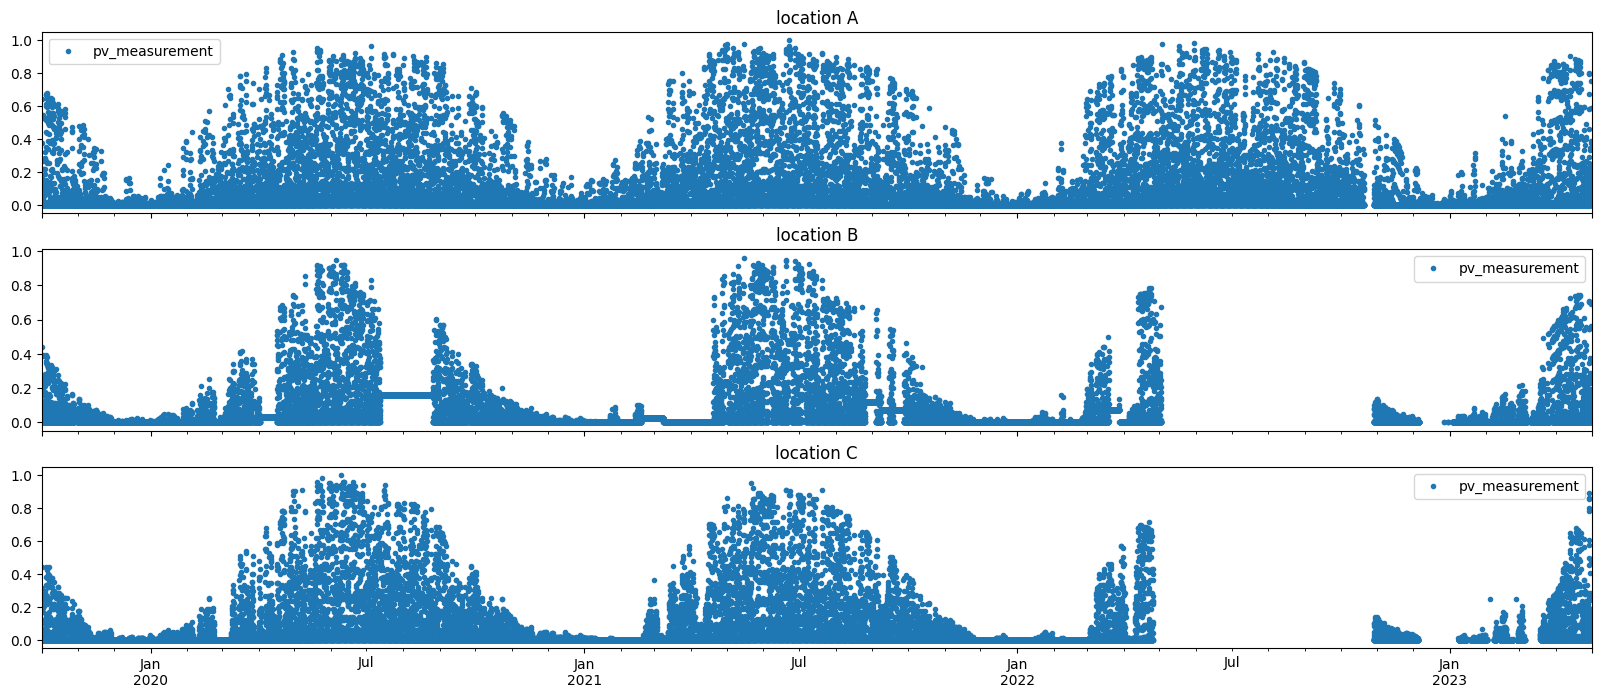

In [83]:
fig, axs = plt.subplots(3, 1, figsize=(20,8), sharex=True)
train_a[['pv_measurement']].plot(ax=axs[0], title="location A", style=".")
train_b[['pv_measurement']].plot(ax=axs[1], title="location B", style=".")
train_c[['pv_measurement', ]].plot(ax=axs[2], title="location C", style=".")

### Replace constants values with NaN

In [84]:
def replace_consecutive_identical_with_nan(dataframe):
    """
    Process the dataframe by replacing consecutive identical values with NaN.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe to process.
    
    Returns:
    - pd.DataFrame: The processed dataframe.
    """
    # Create a mask where values are the same as the previous row
    mask = dataframe['pv_measurement'] == dataframe['pv_measurement'].shift(1)
    
    # Replace those values with NaN
    dataframe.loc[mask, 'pv_measurement'] = np.nan
    
    return dataframe

# Apply the function to each dataframe
train_a = replace_consecutive_identical_with_nan(train_a)
train_b = replace_consecutive_identical_with_nan(train_b)
train_c = replace_consecutive_identical_with_nan(train_c)

2019-10-01 00:00:00
2019-10-01 00:00:00
2019-10-01 00:00:00


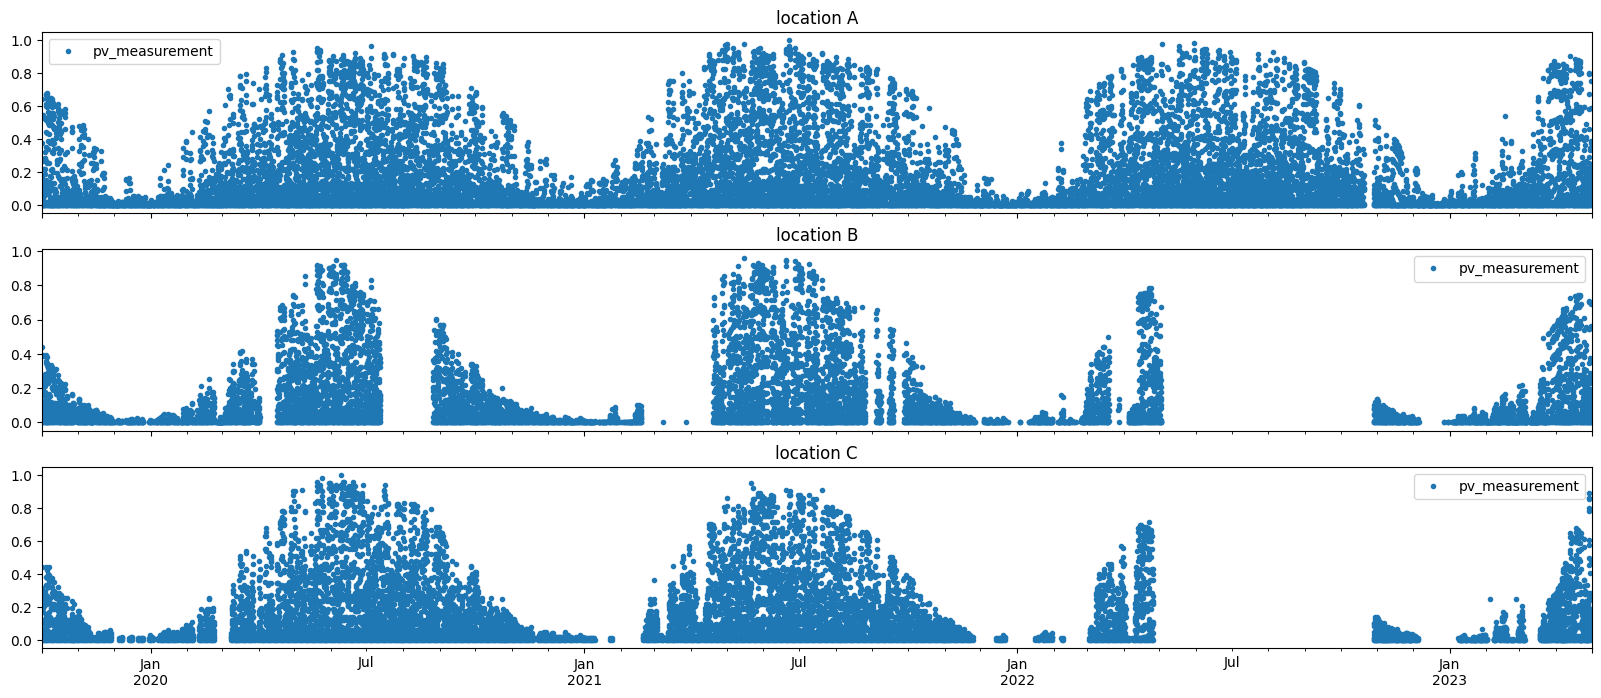

In [85]:
fig, axs = plt.subplots(3, 1, figsize=(20,8), sharex=True)
train_a[['pv_measurement']].plot(ax=axs[0], title="location A", style=".")
train_b[['pv_measurement']].plot(ax=axs[1], title="location B", style=".")
train_c[['pv_measurement', ]].plot(ax=axs[2], title="location C", style=".")

print(train_a.index.min())
print(train_b.index.min())
print(train_c.index.min())

### Replace missing values with NaN

In [86]:
def fill_missing_dates_in_dataframe(df, frequency='H'):
    """
    Fill missing dates in the index of a dataframe with NaN values.
    
    Parameters:
    - df (DataFrame): Input dataframe with a datetime index.
    - frequency (str): Frequency string to determine the date range (default is 'H' for hourly).
    
    Returns:
    - DataFrame with filled missing dates.
    """
    
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=frequency)
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    
    return pd.concat([df, missing_df]).sort_index()


train_b = fill_missing_dates_in_dataframe(train_b)
train_c = fill_missing_dates_in_dataframe(train_c)

## Replace NaN with Y-values from dataset A

In [87]:
def replace_nans_from_source(target_df, source_df):
    """
    Replace NaN values in the 'pv_measurement' column of the target dataframe using values 
    from the 'pv_measurement' column of the source dataframe.
    
    Args:
    - target_df (pd.DataFrame): The dataframe whose 'pv_measurement' NaN values need to be replaced.
    - source_df (pd.DataFrame): The dataframe which provides the 'pv_measurement' column for replacement.
    
    Returns:
    - pd.DataFrame: The target dataframe with NaN values replaced.
    """
    target_df['pv_measurement'] = target_df['pv_measurement'].combine_first(source_df['pv_measurement'])
    return target_df


# Use the function:
train_b = replace_nans_from_source(train_b, train_a)
train_c = replace_nans_from_source(train_c, train_a)

In [88]:
import pandas as pd

def merge_with_one_hot_encoding(dfs, names):
    """
    Merge a list of dataframes with one hot encoding to identify the source dataframe.
    
    Parameters:
    - dfs (list of DataFrames): List of dataframes to merge.
    - names (list of str): Names corresponding to each dataframe for one-hot encoding.
    
    Returns:
    - A merged dataframe with one-hot encoding columns.
    """
    # List to store dataframes after one-hot encoding
    encoded_dfs = []
    
    # Iterate over dataframes and names
    for df, name in zip(dfs, names):
        # Copy the dataframe to avoid modifying the original
        df_copy = df.copy()
        # Create a one-hot encoding column
        df_copy[name] = int(1)
        # Append to the list
        encoded_dfs.append(df_copy)
    
    # Concatenate all encoded dataframes
    merged_df = pd.concat(encoded_dfs, axis=0, sort=True).fillna(0)
    
    # Convert one-hot encoded columns back to integers
    for name in names:
        merged_df[name] = merged_df[name].astype(int)
    
    return merged_df

# Define the list of dataframes and their corresponding names
dfs = [train_a, train_b, train_c]
names = ["location_A", "location_B", "location_C"]

# Call the function
y_values_df = merge_with_one_hot_encoding(dfs, names)

# Drop the "location" column
y_values_df = y_values_df.drop("location", axis=1)

# Display the head of the merged dataframe
y_values_df.head()


,location_A,location_B,location_C,pv_measurement
2019-10-01 00:00:00,1,0,0,0.0
2019-10-01 01:00:00,1,0,0,0.0
2019-10-01 02:00:00,1,0,0,0.0
2019-10-01 03:00:00,1,0,0,0.0
2019-10-01 04:00:00,1,0,0,0.0


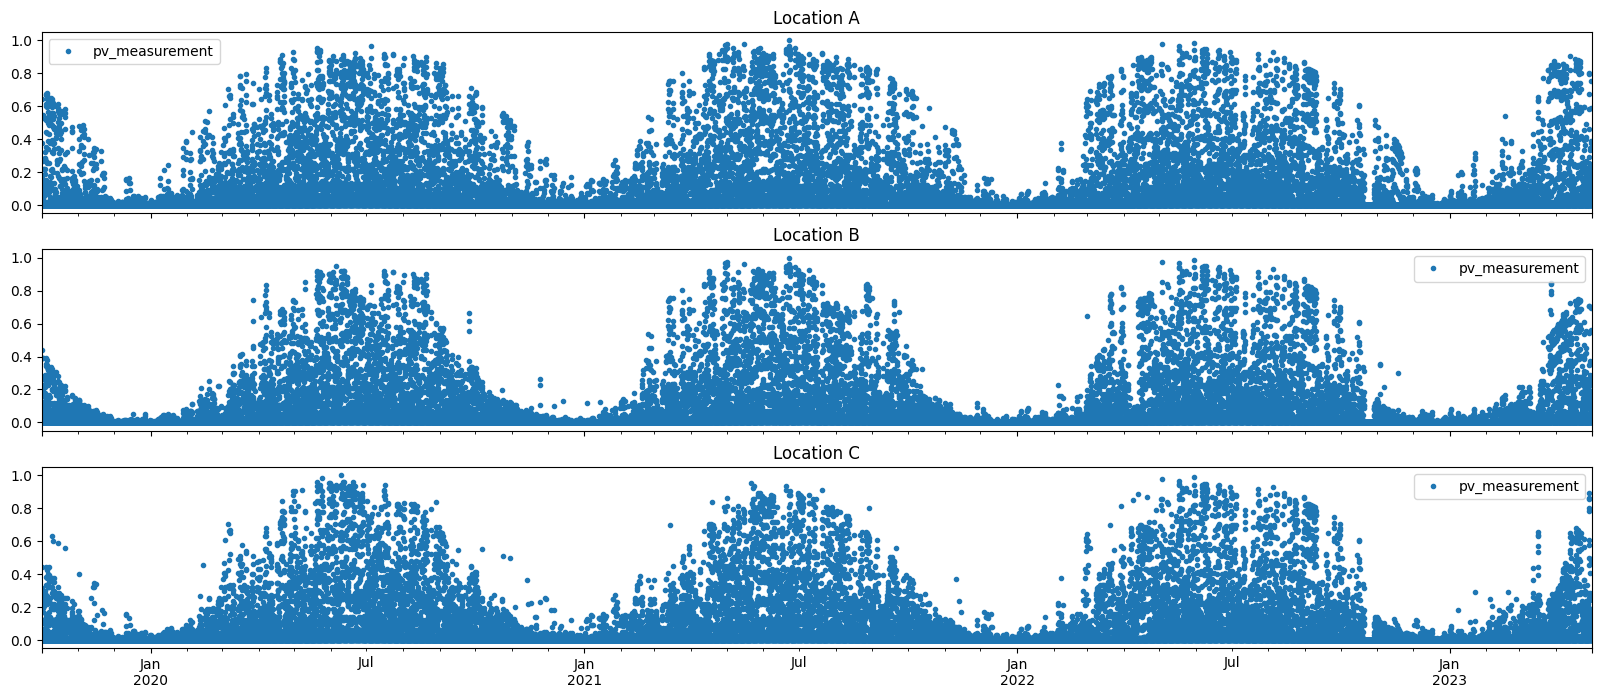

In [89]:
# Extract rows corresponding to each location
location_a = y_values_df.query('location_A == 1')
location_b = y_values_df.query('location_B == 1')
location_c = y_values_df.query('location_C == 1')

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(20,8), sharex=True)
location_a[['pv_measurement']].plot(ax=axs[0], title="Location A", style=".")
location_b[['pv_measurement']].plot(ax=axs[1], title="Location B", style=".")
location_c[['pv_measurement']].plot(ax=axs[2], title="Location C", style=".")

plt.show()


# Data Cleaning: X-values

### Set date_forecast as index and drop data_calc

In [90]:
all_x_train = [
    X_train_observed_a, 
    X_train_estimated_a, 
    X_train_observed_b, 
    X_train_estimated_b, 
    X_train_observed_c, 
    X_train_estimated_c
]

for df in all_x_train:
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    df.drop(columns="date_calc", errors="ignore", inplace=True)


### Concatenates two dataframes, adds missing date indices, and replaces NaN values

In [91]:
def concat_datasets(df1, df2):
    x = pd.concat([df1, df2], ignore_index=False)
    return x

def add_missing_dates(df):
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    df = pd.concat([df, missing_df]).sort_index()
    return df

def fix_dataset(obs, est):
    x = concat_datasets(obs, est)
    x = add_missing_dates(x)
    x = x.combine_first(X_train_observed_a)
    return x

x_b = fix_dataset(X_train_observed_b, X_train_estimated_b)
x_c = fix_dataset(X_train_observed_c, X_train_estimated_c)

all_x_train = [X_train_observed_a, X_train_estimated_a, x_b, x_c]

### Resampling and Labeling DataFrames

In [92]:
# Resample all DataFrames to an hourly frequency
for i in range(len(all_x_train)):
    all_x_train[i] = all_x_train[i].resample('60min').sum()

# Separate combined DataFrames
X_train_observed_a, X_train_estimated_a, x_b, x_c = all_x_train

# Label data by location
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
x_b['location'] = 'B'
x_c['location'] = 'C'

# Label data by estimated/observed status
X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
x_b['estimated'], x_b.loc[x_b.index > X_train_estimated_b.index.min(), 'estimated'] = 0, 1
x_c['estimated'], x_c.loc[x_c.index > X_train_estimated_c.index.min(), 'estimated'] = 0, 1


### Combining DataFrames and One-hot Encoding

In [93]:
# Combine all DataFrames and sort by index
X = pd.concat(all_x_train, ignore_index=False)
X = X.sort_index()

# One-hot encode location information
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

# Merging Data

In [94]:
# Merge processed data with target data
df = pd.merge(y_values_df, X, left_on=[y_values_df.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

# Set and sort the index
df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

# Data Cleaning Done!

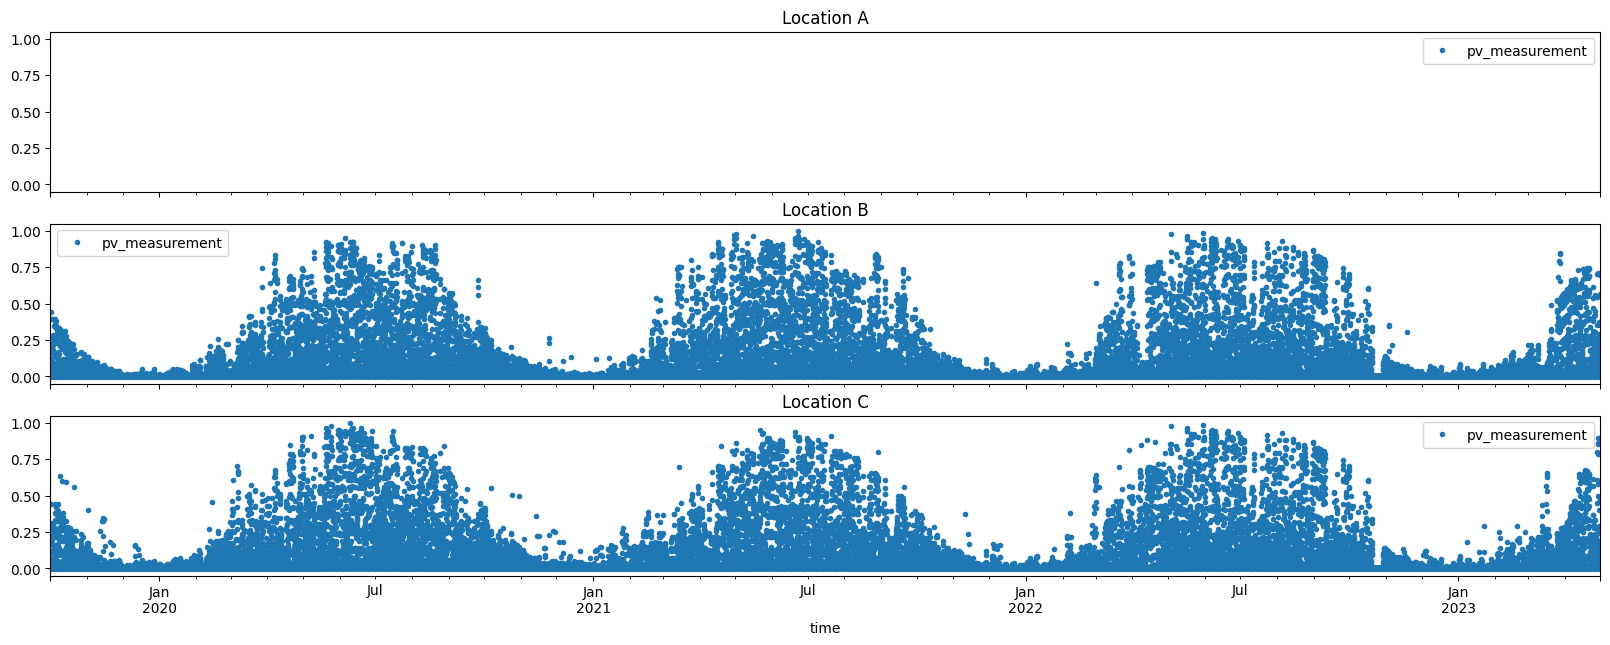

In [95]:
# Extract rows corresponding to each location
location_a = df.query('location_A == 1')
location_b = df.query('location_B == 1')
location_c = df.query('location_C == 1')

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(20,8), sharex=True)
location_a[['pv_measurement']].plot(ax=axs[0], title="Location A", style=".")
location_b[['pv_measurement']].plot(ax=axs[1], title="Location B", style=".")
location_c[['pv_measurement']].plot(ax=axs[2], title="Location C", style=".")

plt.show()

# Feature Engineering

In [96]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)


In [97]:
df.columns

Index(['location_A', 'location_B', 'location_C', 'pv_measurement',
       'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 

In [98]:
FEATURES = ['dayofyear', 
            'hour', 
            'dayofweek', 
            'quarter', 
            'month', 
            'year',
            'sun_elevation:d',
            'total_cloud_cover:p',
            'direct_rad_1h:J',
            'ceiling_height_agl:m'
            ]

TARGET = 'pv_measurement'

# Train/Test Split

In [99]:
split = '01-01-2023'

train = df.loc[df.index < split]
test = df.loc[df.index >= split]

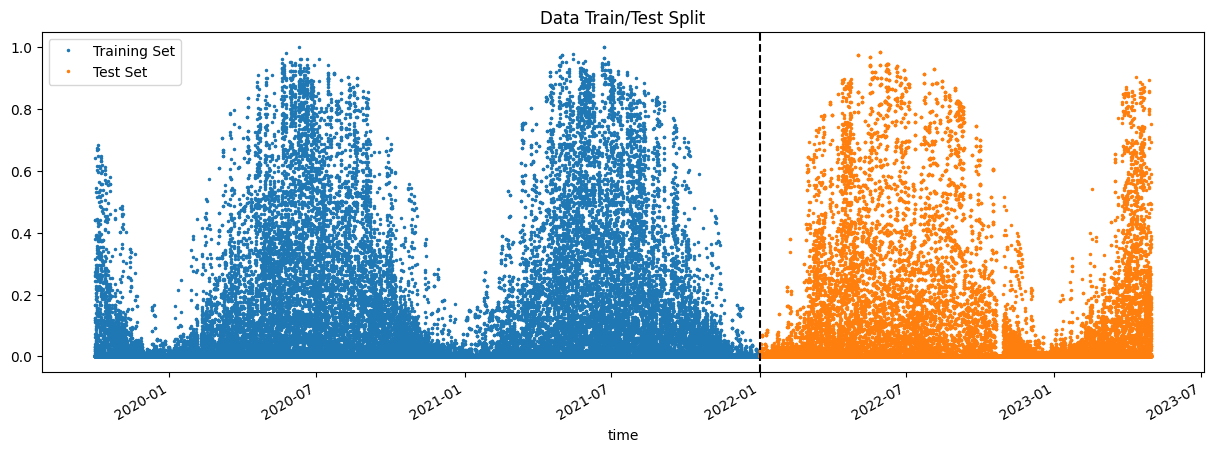

In [100]:
split = '01-01-2022'

train = df.loc[df.index < split]
test = df.loc[df.index >= split]

fig, ax = plt.subplots(figsize=(15, 5))
train["pv_measurement"].plot(ax=ax, label='Training Set', title='Data Train/Test Split', style=".", markersize=3)
test["pv_measurement"].plot(ax=ax, label='Test Set', style=".", markersize=3)
ax.axvline(split, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [101]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# The Machine Learning Model

In [102]:
reg = xgb.XGBRegressor()

parameters = {
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "n_estimators": [100, 500, 1000],
}

grid_search = GridSearchCV(estimator=reg, param_grid=parameters, verbose=100)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:0.14135	validation_1-rmse:0.14359


/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Use

[99]	validation_0-rmse:0.04252	validation_1-rmse:0.08679


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

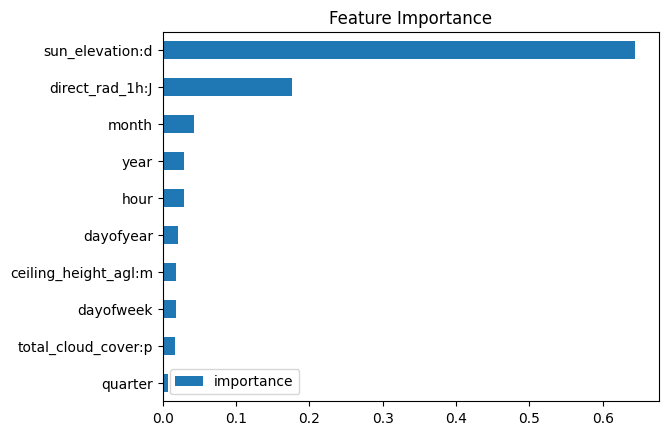

In [103]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Data

In [104]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Use

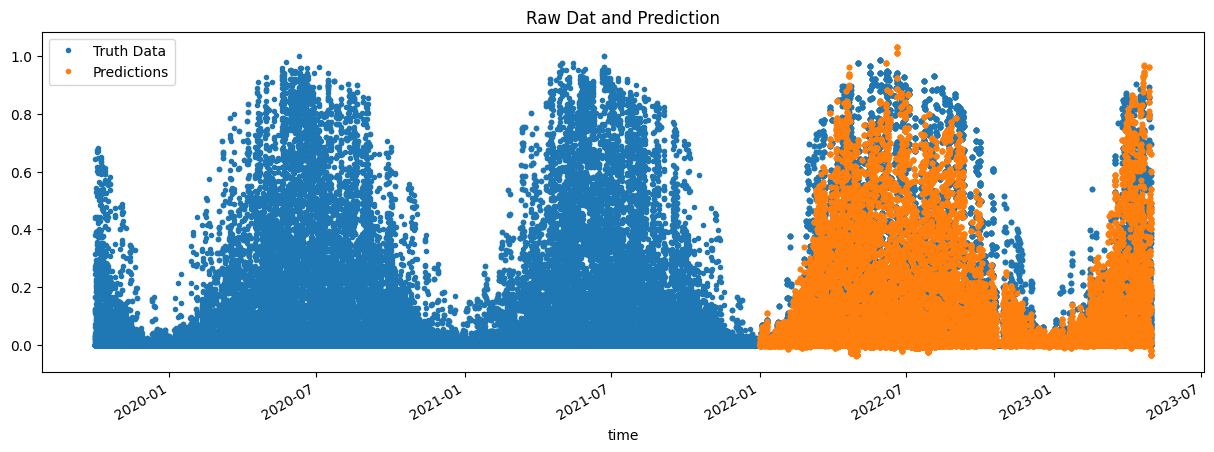

In [105]:

ax = df[['pv_measurement']].plot(figsize=(15, 5), style='.')
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

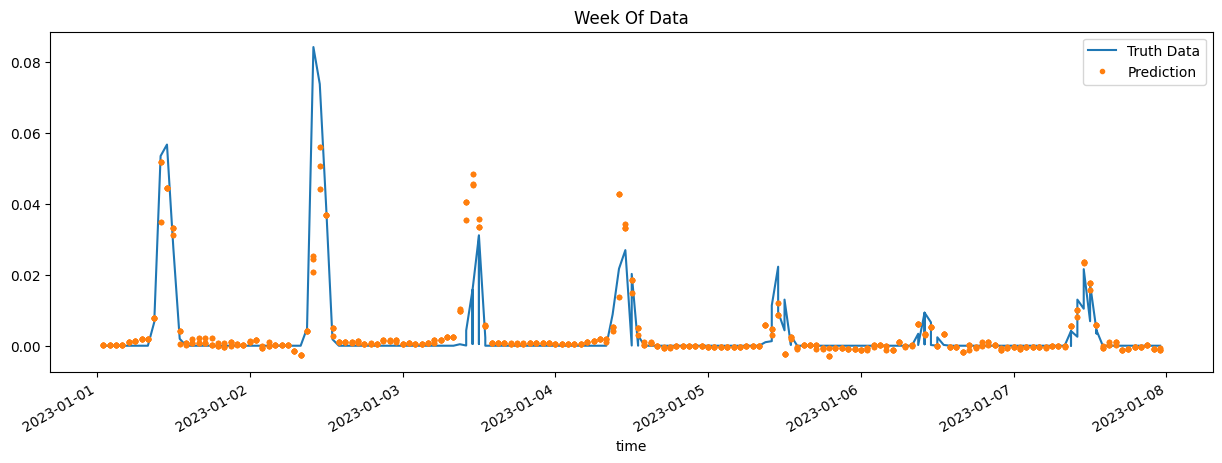

In [106]:
ax = df.loc[(df.index > "01-01-2023") & (df.index < "01-08-2023")]['pv_measurement'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > "01-01-2023") & (df.index < "01-08-2023")]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [107]:
score = np.sqrt(mean_squared_error(test['pv_measurement'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.09


# Now Saving the Model!

In [108]:
import joblib

joblib.dump(reg, 'xgboost_model.pkl')

predictions = reg.predict(X_test)

predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

n = len(predictions)

# De-normalizing
predictions.loc[:n//3, 'prediction'] = scaler_a.inverse_transform(predictions.loc[:n//3, 'prediction'].values.reshape(-1, 1))[:, 0]
predictions.loc[n//3:2*n//3, 'prediction'] = scaler_b.inverse_transform(predictions.loc[n//3:2*n//3, 'prediction'].values.reshape(-1, 1))[:, 0]
predictions.loc[2*n//3:, 'prediction'] = scaler_c.inverse_transform(predictions.loc[2*n//3:, 'prediction'].values.reshape(-1, 1))[:, 0]


predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0 #remove negative values
predictions.to_csv('predictions.csv', index=False)

/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/marcusfuglestad/Desktop/NTNU/TDT4173MachineLearning/GroupAssignment/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Use